# Nonlinear Fitting

What about the case of fitting to a function where the fit parameters enter in a nonlinear fashion?
For example:

$$f(x; a_0, a_1) = a_0 e^{a_1 x}$$

One trick that is often used for something like this is to transform the data.  So instead of fitting the data $(x_i, y_i)$, you instead fit $(x_i, \log y_i)$, and then our fitting function is:

$$\log f(x; a_0, a_1) = a_1 x + \log a_0$$

which is linear.

However, when there are errors associated with the $y_i$, the errors do not necessarily transform the correct way when you take the logarithm.  

So let's look at how we would fit directly to a nonlinear function.

We'll minimize the same fitting function:

$$\chi^2 = \sum_{i=1}^N \frac{(y_i - f(x; {\bf a}))^2}{\sigma_i^2}$$

with fitting parameters ${\bf a} = (a_1, \ldots, a_M)^\intercal$.

Now we take the derivatives with respect to each parameter, $a_k$:

$$\frac{\partial \chi^2}{\partial a_k} = -2 \sum_{i=1}^N \frac{(y_i - f(x, {\bf a}))}{\sigma_i^2} \frac{\partial f}{\partial a_k} = 0$$

Let's define $g_k \equiv {\partial \chi^2}/{\partial a_k}$, then we have

$${\bf g}({\bf a}) = \left ( \begin{array}{c} g_1({\bf a}) \\ g_2({\bf a}) \\ \vdots \\ g_M({\bf a}) \end{array} \right ) = 0$$

This is a nonlinear system of $M$ equations and $M$ unknowns.  We can solve this using the same multivariate Newton's method we looked at before:

* Take an initial guess at the fit parameters, ${\bf a}^{(k)}$
* Solve the system ${\bf J}\delta {\bf a} = -{\bf g}$, where $J_{ij} = \partial g_i/\partial a_j$ is the Jacobian
* Correct the initial guess, ${\bf a}^{(k+1)} = {\bf a}^{(k)} + \delta {\bf a}$

As we've seen with Newton's method, convergence will be very sensitive to the initial guess.

## Fitting an exponential

Let's try this out on data that is constructed to follow an exponential trend.

First let's construct the data, and perturb it with some errors.  We'll take the form:

$$y = a_0 e^{a_1 x}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

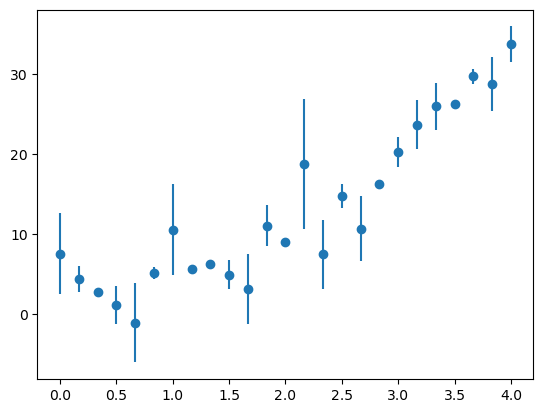

In [3]:
# make up some experimental data
a0 = 2.5
a1 = 2./3.
sigma = 4.0

N = 25

x = np.linspace(0.0, 4.0, N)
r = sigma * np.random.randn(N)
y = a0 * np.exp(a1 * x) + r
yerr = np.abs(r)

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr, fmt="o")

Now, let's compute our vector ${\bf g}$ that we will zero:

\begin{align*}
g_0 &= \frac{\partial \chi^2}{\partial a_0} = -2 \sum_{i=1}^N \frac{(y_i - a_0 e^{a_1 x_i})}{\sigma_i^2} (e^{a_1 x_i}) \\
g_1 &= \frac{\partial \chi^2}{\partial a_1} = -2 \sum_{i=1}^N \frac{(y_i - a_0 e^{a_1 x_i})}{\sigma_i^2} (x_i a_0 e^{a_1 x_i})
\end{align*}

We can divide out the $-2$ in each expression.  We'll keep the overall $a_0$ in the expression, to deal with the case where it might be $0$.

Let's write a function to compute this:

In [4]:
def g(x, y, yerr, a):
    """compute the nonlinear functions we minimize.  Here a is the vector
    of fit parameters"""
    
    a0, a1 = a
    
    g0 = np.sum(np.exp(a1 * x) * (y - a0 * np.exp(a1 * x)) / yerr**2)
    g1 = a0 * np.sum(x * np.exp(a1 * x) * (y - a0 * np.exp(a1 * x)) / yerr**2)
    
    return np.array([g0, g1])

We also need the Jacobian.  We could either compute this numerically, via differencing, or analytically.  We'll do the latter.

\begin{align*}
\frac{\partial g_0}{\partial a_0} &= -\sum_{i=1}^N \frac{e^{2a_1 x_i}}{\sigma_i^2} \\
\frac{\partial g_0}{\partial a_1} &= \sum_{i=1}^N \frac{x_i e^{a_1 x_i} (y_i - 2 a_0 e^{a_1 x_i})}{\sigma_i^2} \\
\frac{\partial g_1}{\partial a_0} &=  \sum_{i=1}^N \frac{x_i e^{a_1 x_i} (y_i - 2 a_0 e^{a_1 x_i})}{\sigma_i^2} \\
\frac{\partial g_1}{\partial a_1} &= \sum_{i=1}^N \frac{a_0 x_i^2 e^{a_1 x_i} (y_i - 2 a_0 e^{a_1 x_i})}{\sigma_i^2}
\end{align*}

Notice that the Jacobian is symmetric:

$${\bf J} = \left ( \begin{array}{cc}
         \frac{\partial g_0}{\partial a_0} & \frac{\partial g_0}{\partial a_1} \\
         \frac{\partial g_1}{\partial a_0} & \frac{\partial g_1}{\partial a_1} \end{array} \right )
= \left ( \begin{array}{cc}
         \frac{\partial^2 \chi^2}{\partial a_0^2} & \frac{\partial^2 \chi^2}{\partial a_0 \partial a_1} \\
         \frac{\partial^2 \chi^2}{\partial a_1 \partial a_0} & \frac{\partial^2 \chi^2}{\partial a_1^2} \end{array} \right )       
$$

This is called the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix).

Let's write this function:

In [5]:
def jac(x, y, yerr, a):
    """ compute the Jacobian of the function g"""

    a0, a1 = a
    
    dg0da0 = -np.sum(np.exp(2.0 * a1 * x) / yerr**2)
    dg0da1 = np.sum(x * np.exp(a1 * x) * (y - 2.0 * a0 * np.exp(a1 * x)) / yerr**2)
    dg1da0 = dg0da1
    dg1da1 = np.sum(a0 * x**2 * np.exp(a1 * x) * (y - 2.0 * a0 * np.exp(a1 * x)) / yerr**2)
    
    return np.array([[dg0da0, dg0da1],
                     [dg1da0, dg1da1]])

In [6]:
def fit(aguess, x, y, yerr, tol=1.e-5):
    """ aguess is the initial guess to our fit parameters.  x and y
        are the vector of points that we are fitting to, and yerr are
        the errors in y"""
    
    avec = aguess.copy()

    err = 1.e100
    while err > tol:

        # get the jacobian
        J = jac(x, y, yerr, avec)

        print("condition number of J: ", np.linalg.cond(J))

        # get the current function values
        gv = g(x, y, yerr, avec)

        # solve for the correction: J da = -g
        da = np.linalg.solve(J, -gv)

        avec += da
        err = np.max(np.abs(da))

    return avec

In [7]:
# initial guesses
aguess = np.array([2.0, 1.0])

# fit
afit = fit(aguess, x, y, yerr)

condition number of J:  132.14504273905686
condition number of J:  181.8703844068089
condition number of J:  381.4640354236112
condition number of J:  4638.594015176583
condition number of J:  102.64728918305431
condition number of J:  150.7070606938618
condition number of J:  172.00157265227045
condition number of J:  222.55965107347478
condition number of J:  391.6320815058459
condition number of J:  2489.7450110930445
condition number of J:  1151.0902598644366
condition number of J:  1016.5381031565403
condition number of J:  1041.7172293049512
condition number of J:  1041.7252410696426


In [8]:
afit

array([2.51306818, 0.66591209])

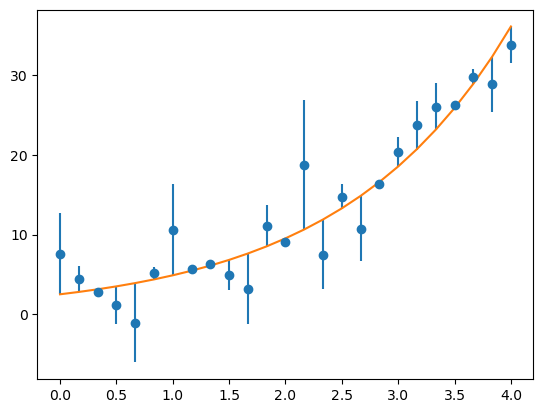

In [9]:
ax.plot(x, afit[0] * np.exp(afit[1] *x))
fig

## Is it a minimum?

We just found an extrema.  Let's plot the surface around our fit parameters to see if it looks like a minimum

In [10]:
npts = 100
a0v = np.linspace(0.5 * afit[0], 2.0 * afit[0], npts)
a1v = np.linspace(0.5 * afit[1], 2.0 * afit[1], npts)

In [11]:
def chisq(a0, a1, x, y, yerr):
    return np.sum((y - a0 * np.exp(a1 * x))**2 / yerr**2)

In [12]:
c2 = np.zeros((npts, npts), dtype=np.float64)
for i, a0 in enumerate(a0v):
    for j, a1 in enumerate(a1v):
        c2[i, j] = chisq(a0, a1, x, y, yerr)

In [13]:
c2.max()

2885495.8835515887

Now we'll plot the (log of) the $\chi^2$

Text(0, 0.5, '$a_1$')

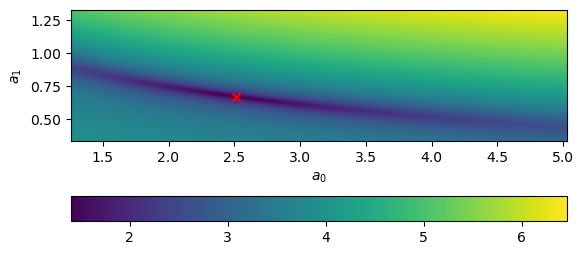

In [14]:
fig, ax = plt.subplots()

# we need to transpose to put a0 on the horizontal
# we use origin = lower to have the origin at the lower left
im = ax.imshow(np.log10(c2).T,
               origin="lower",
               extent=[a0v[0], a0v[-1], a1v[0], a1v[-1]])
fig.colorbar(im, ax=ax, orientation="horizontal")
ax.scatter([afit[0]], [afit[1]], color="r", marker="x")
ax.set_xlabel("$a_0$")
ax.set_ylabel("$a_1$")

It looks like there is a very broad minimum there.

## Troubles

Consider if we tried to add another parameter, fitting to:

$$y = a_0 e^{a_1 x + a_2}$$

here $a_2$ enters the same way as $a_0$, which would give a singular matrix, and make our solution unstable.